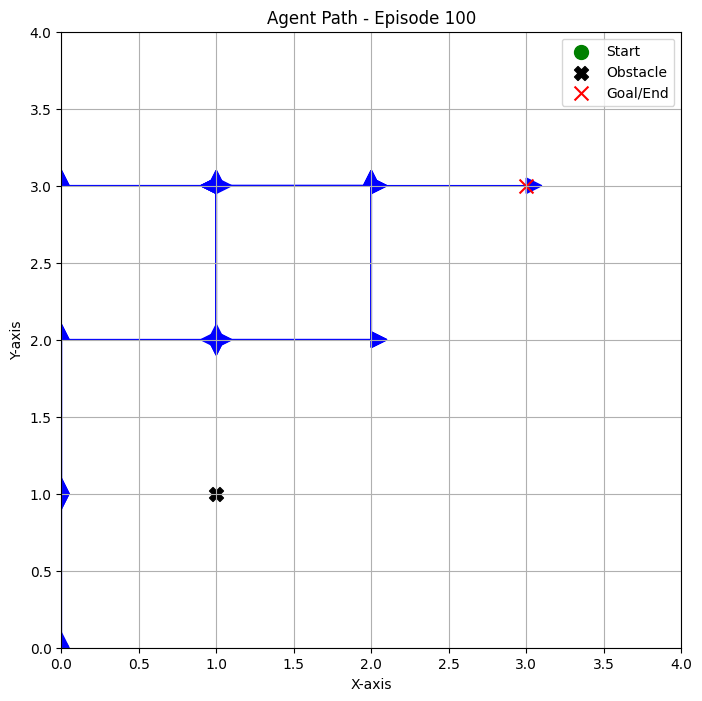

Episode: 100, Avg. Reward: -30.78, Epsilon: 0.9047921471137096


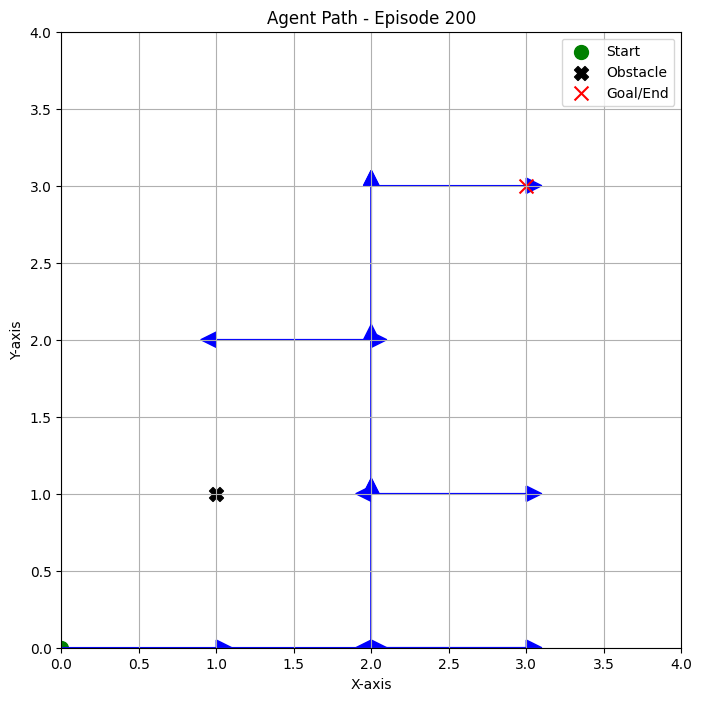

Episode: 200, Avg. Reward: -11.68, Epsilon: 0.818648829478636


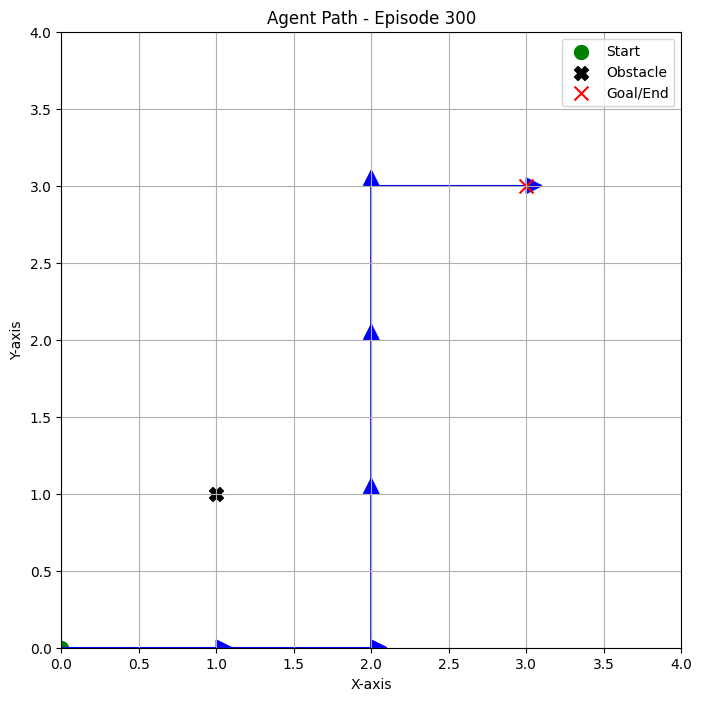

Episode: 300, Avg. Reward: 2.66, Epsilon: 0.7407070321560997


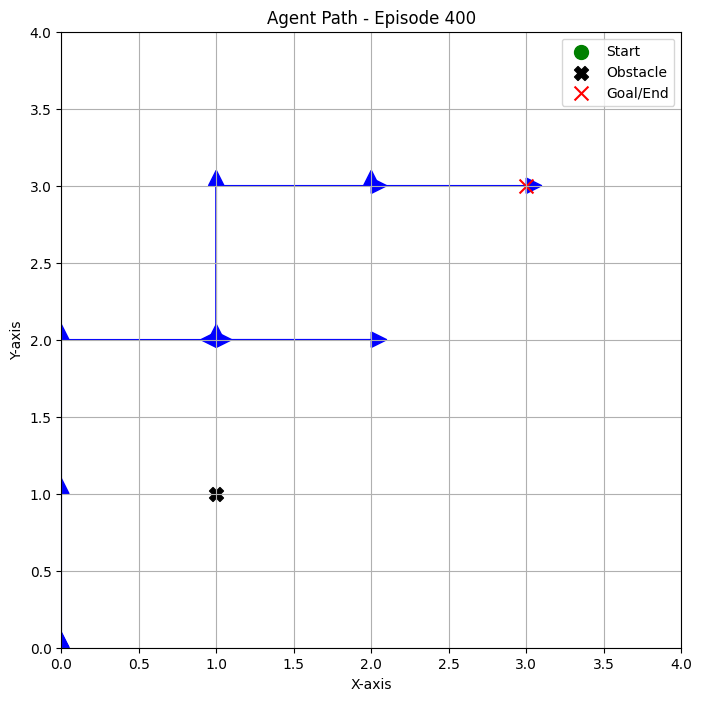

Episode: 400, Avg. Reward: 19.38, Epsilon: 0.6701859060067403


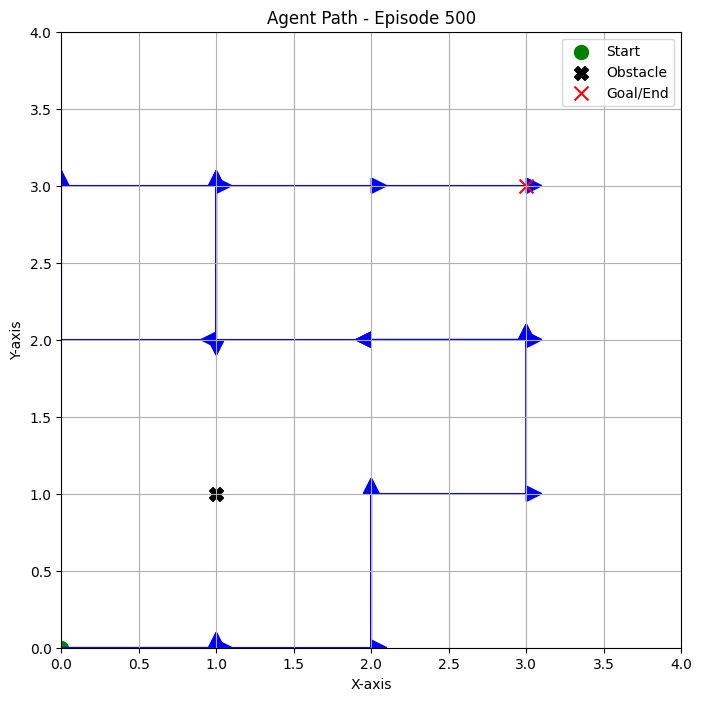

Episode: 500, Avg. Reward: 23.86, Epsilon: 0.6063789448611848


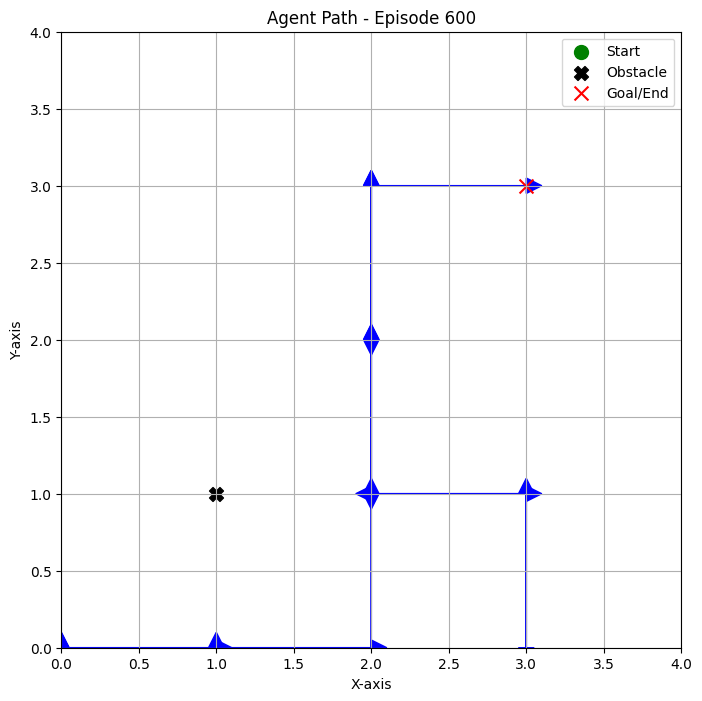

Episode: 600, Avg. Reward: 26.94, Epsilon: 0.5486469074854965


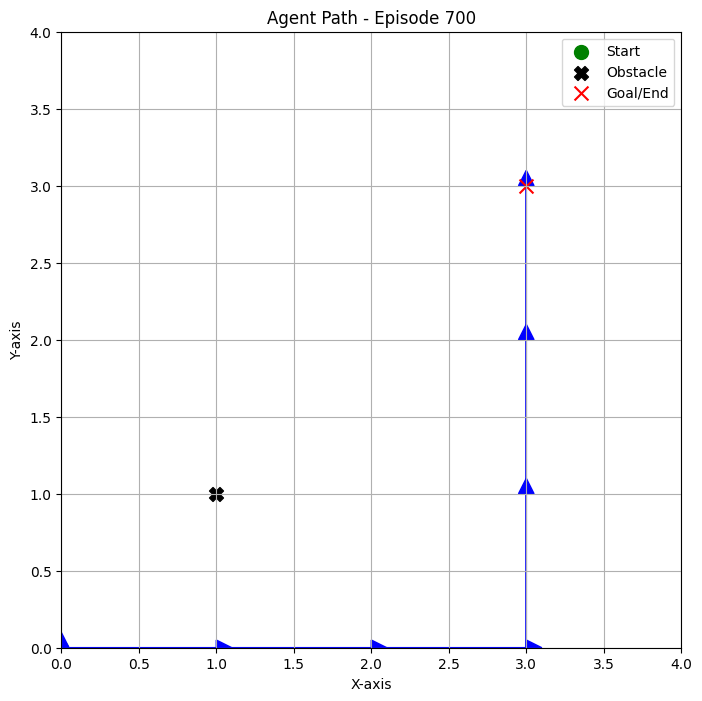

Episode: 700, Avg. Reward: 29.22, Epsilon: 0.4964114134310989


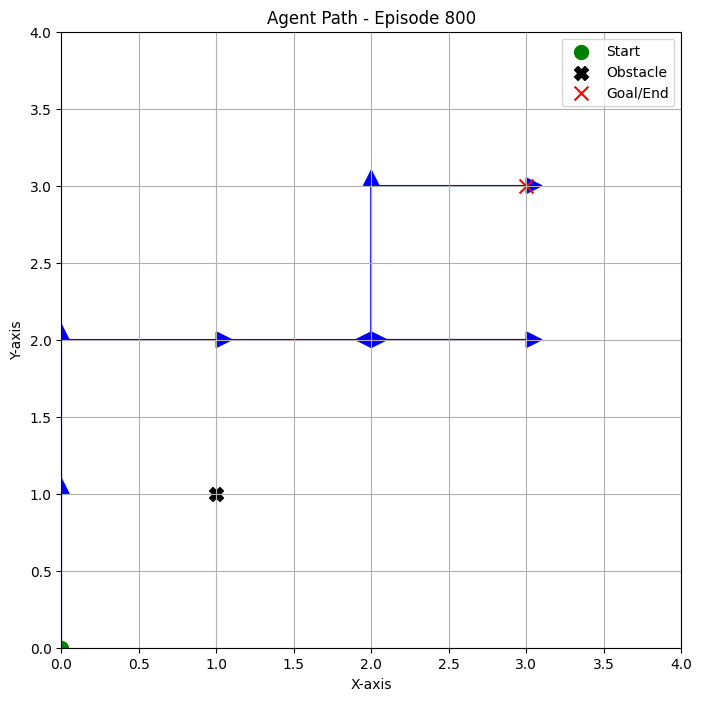

Episode: 800, Avg. Reward: 29.88, Epsilon: 0.4491491486100748


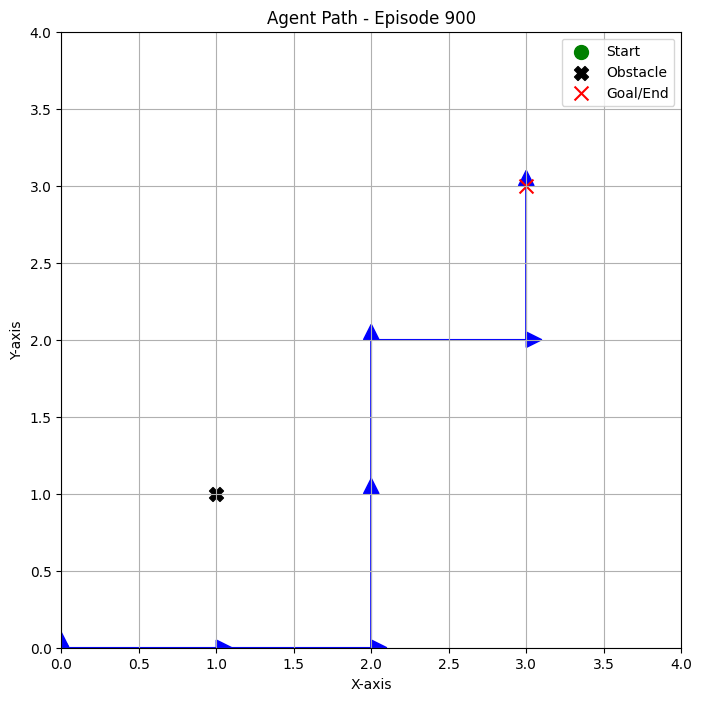

Episode: 900, Avg. Reward: 32.18, Epsilon: 0.4063866225452039


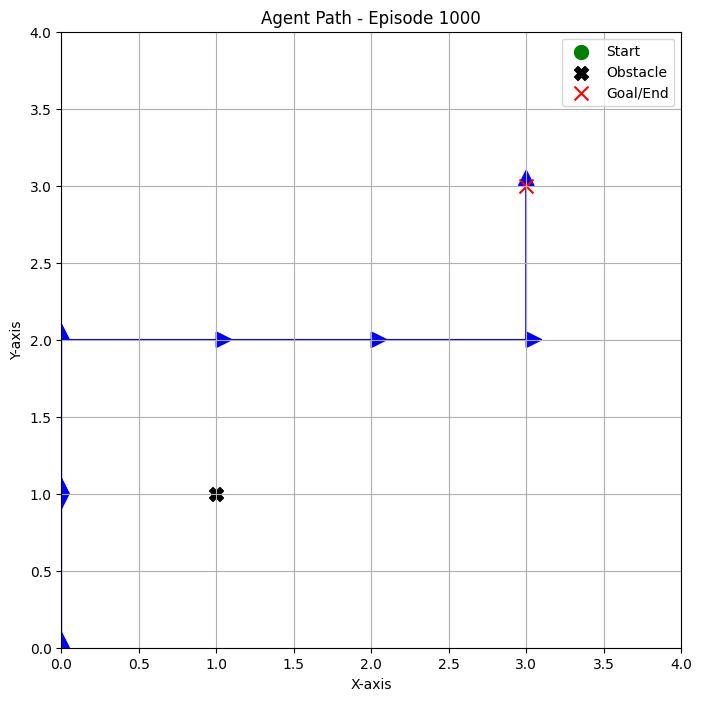

Episode: 1000, Avg. Reward: 33.4, Epsilon: 0.3676954247709635


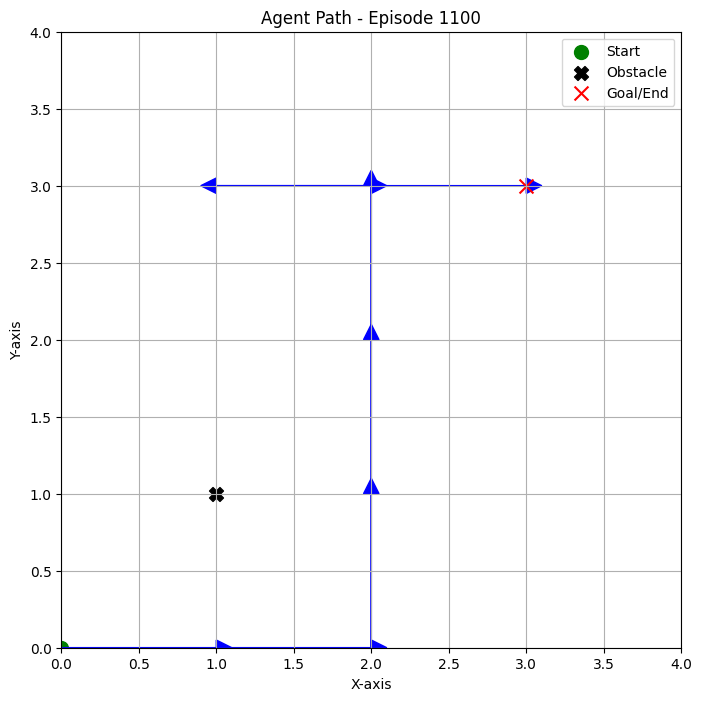

Episode: 1100, Avg. Reward: 33.36, Epsilon: 0.33268793286240766


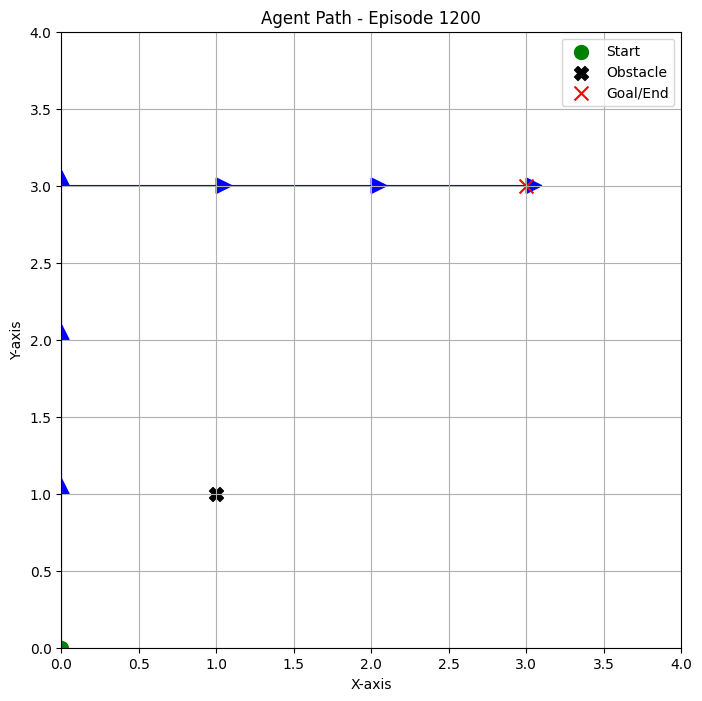

Episode: 1200, Avg. Reward: 34.9, Epsilon: 0.3010134290933992


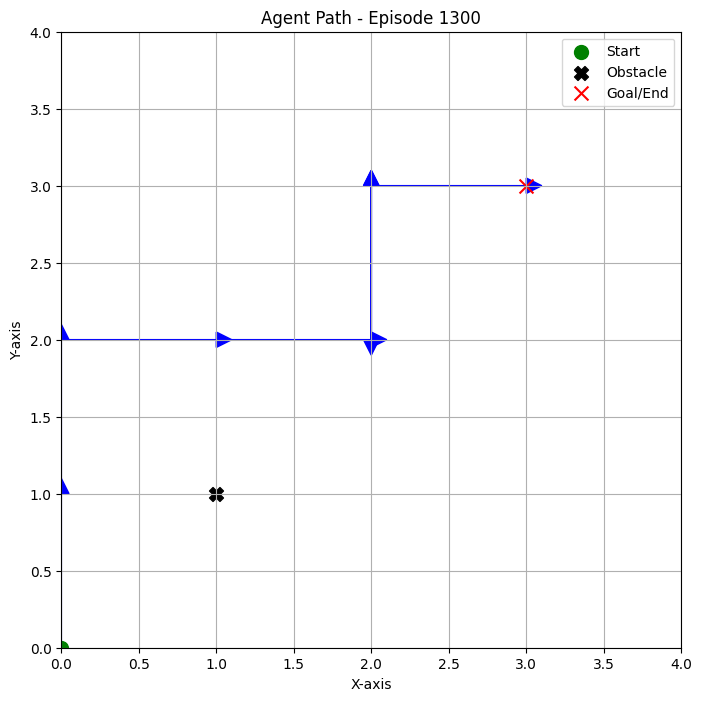

Episode: 1300, Avg. Reward: 35.82, Epsilon: 0.27235458681947705


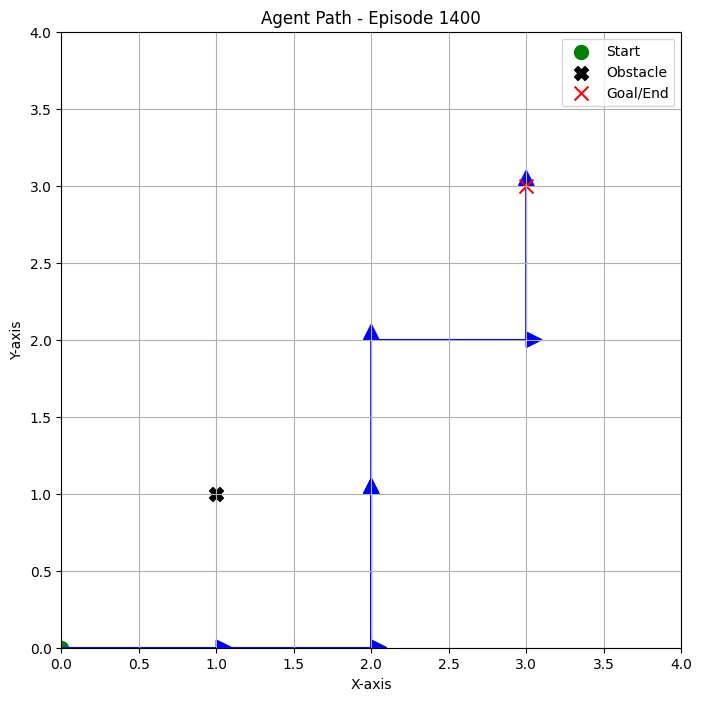

Episode: 1400, Avg. Reward: 36.88, Epsilon: 0.24642429138466176


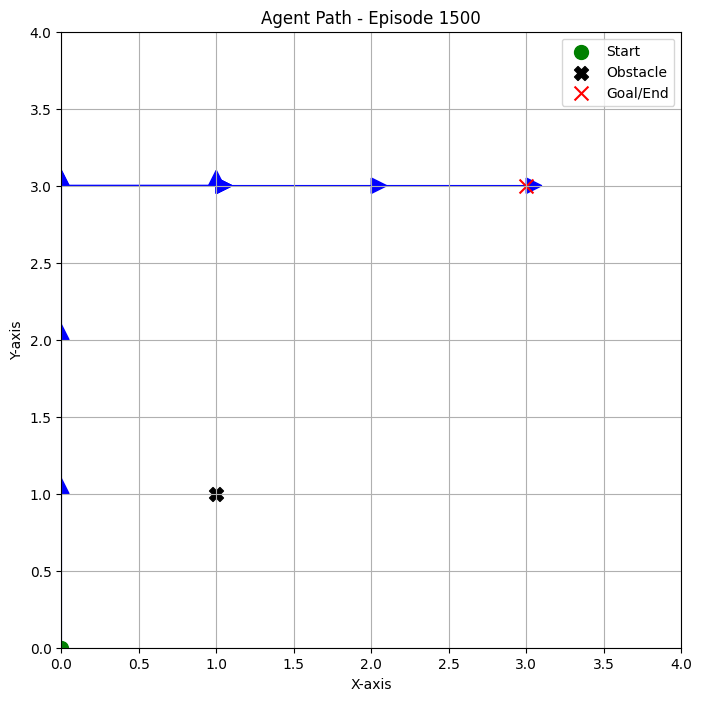

Episode: 1500, Avg. Reward: 36.2, Epsilon: 0.22296276370290227


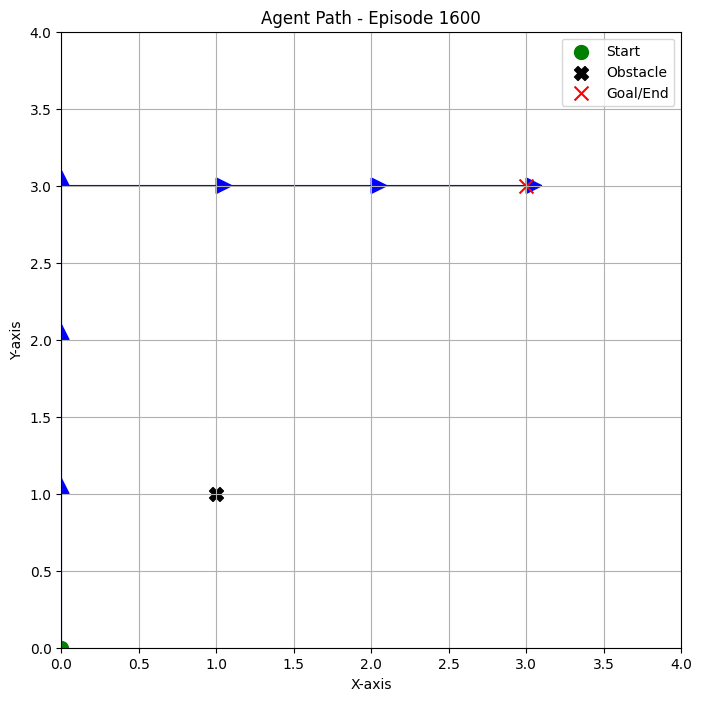

Episode: 1600, Avg. Reward: 37.32, Epsilon: 0.20173495769715546


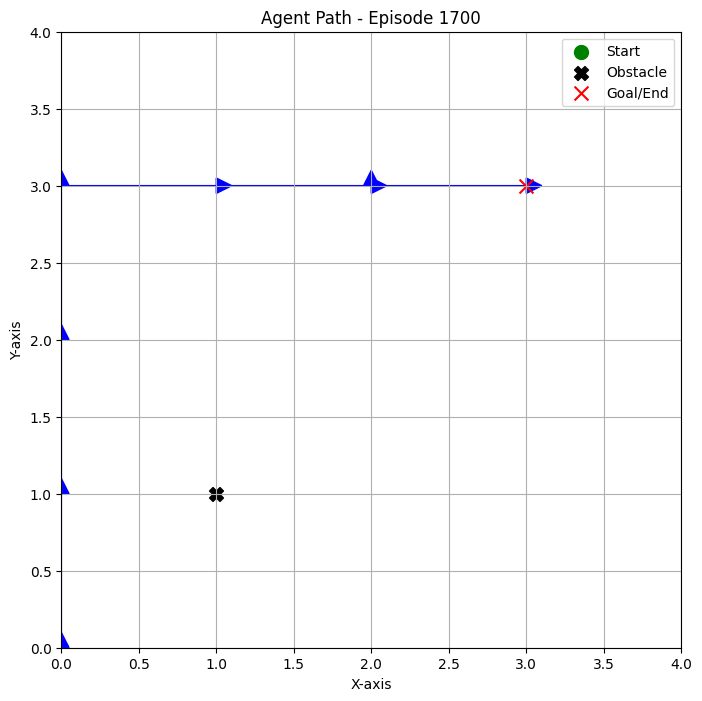

Episode: 1700, Avg. Reward: 37.46, Epsilon: 0.18252820552270246


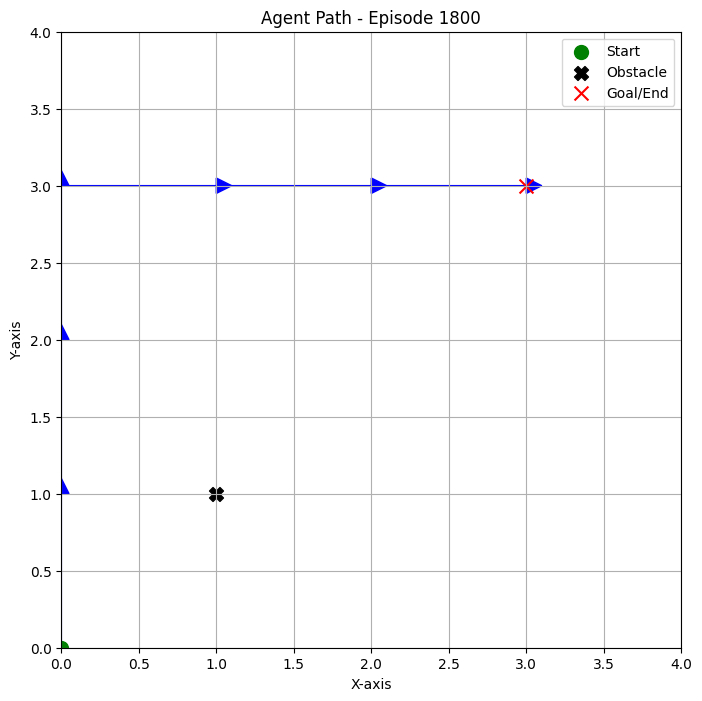

Episode: 1800, Avg. Reward: 37.78, Epsilon: 0.1651500869836984


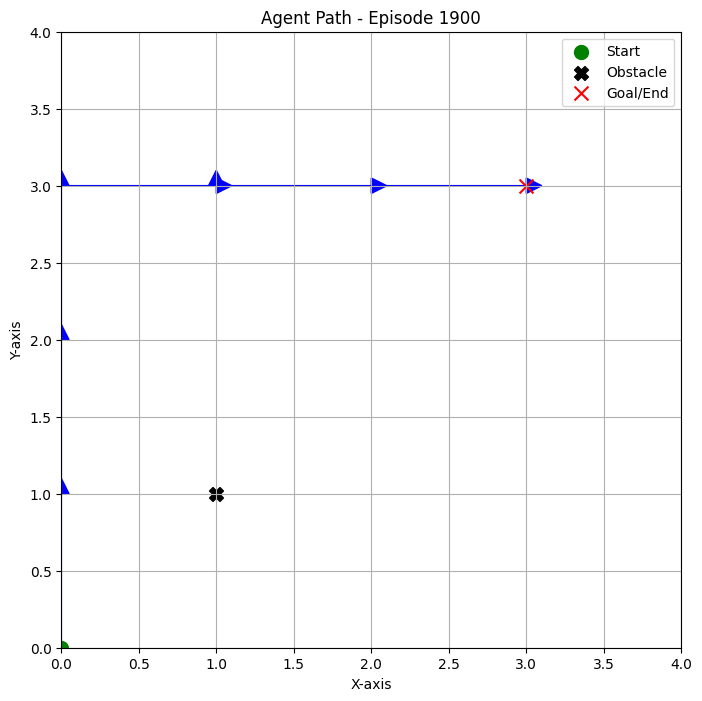

Episode: 1900, Avg. Reward: 38.06, Epsilon: 0.14942650179799613


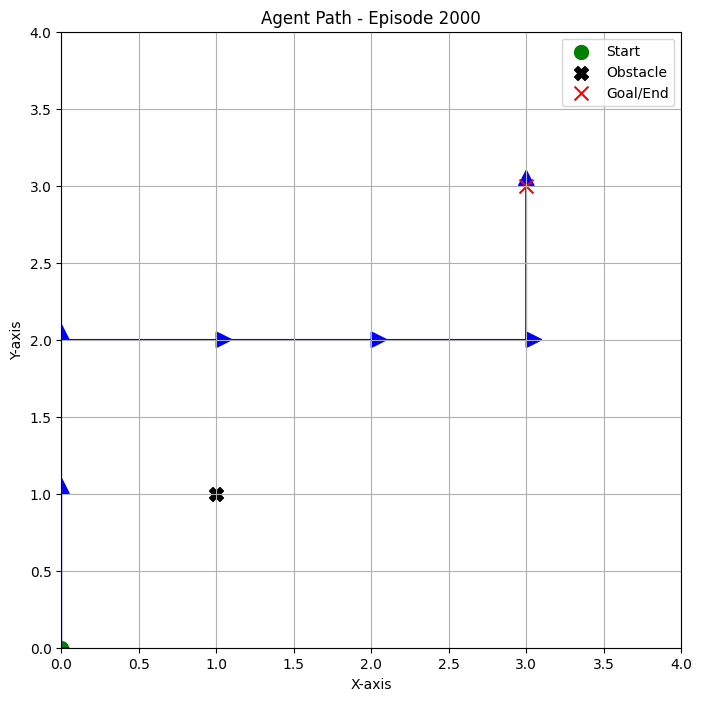

Episode: 2000, Avg. Reward: 37.82, Epsilon: 0.1351999253974994


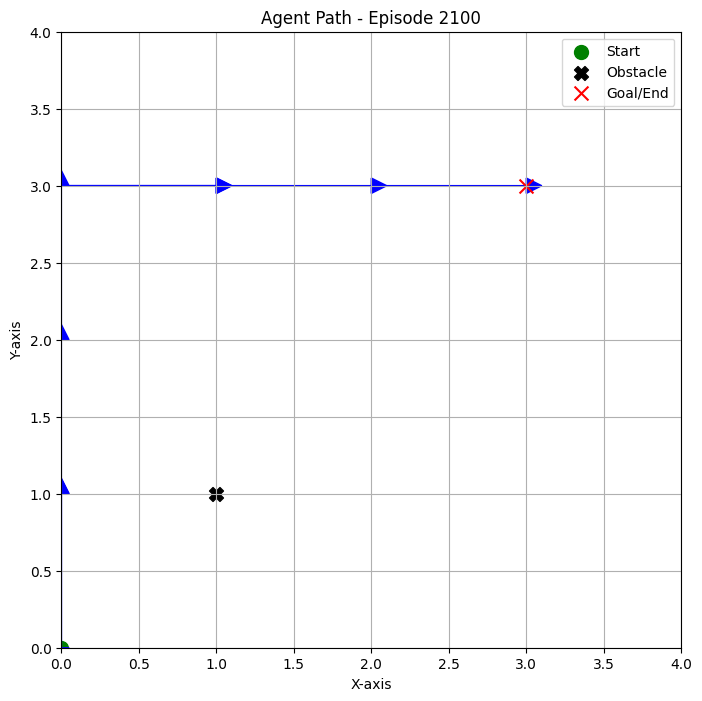

Episode: 2100, Avg. Reward: 38.44, Epsilon: 0.12232783079001676


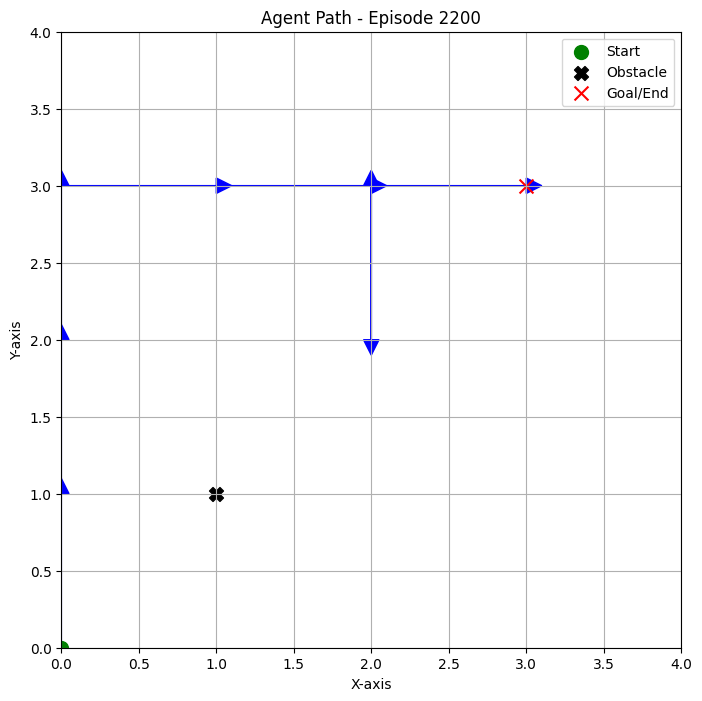

Episode: 2200, Avg. Reward: 38.88, Epsilon: 0.11068126067226178


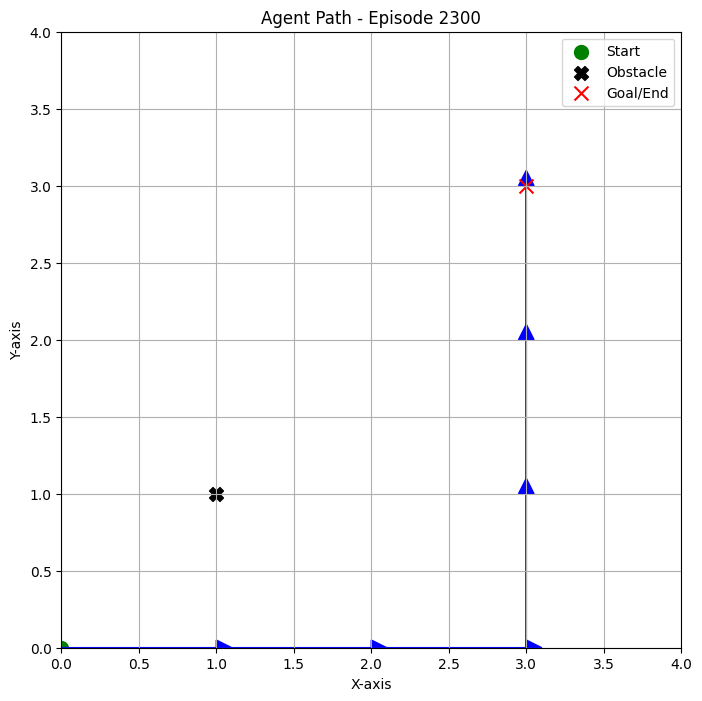

Episode: 2300, Avg. Reward: 38.7, Epsilon: 0.10014353548890782


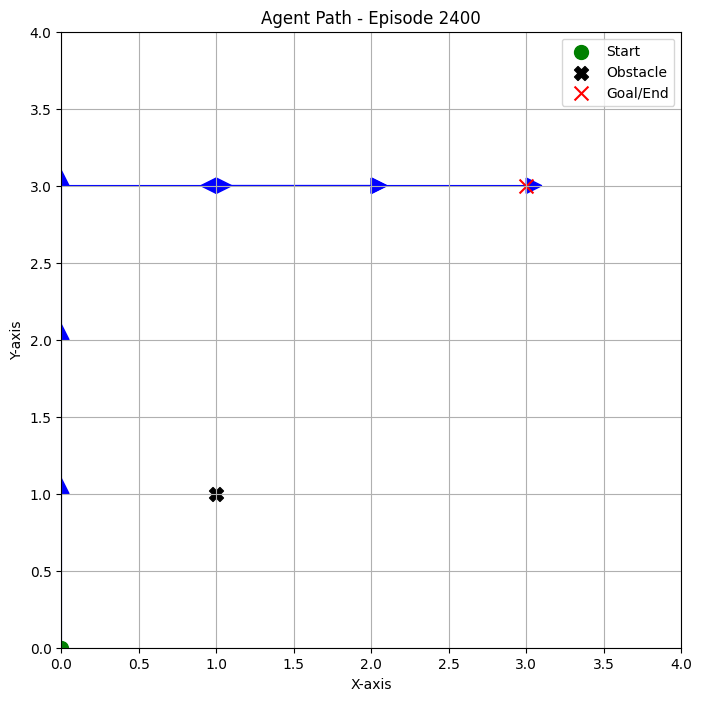

Episode: 2400, Avg. Reward: 38.76, Epsilon: 0.1


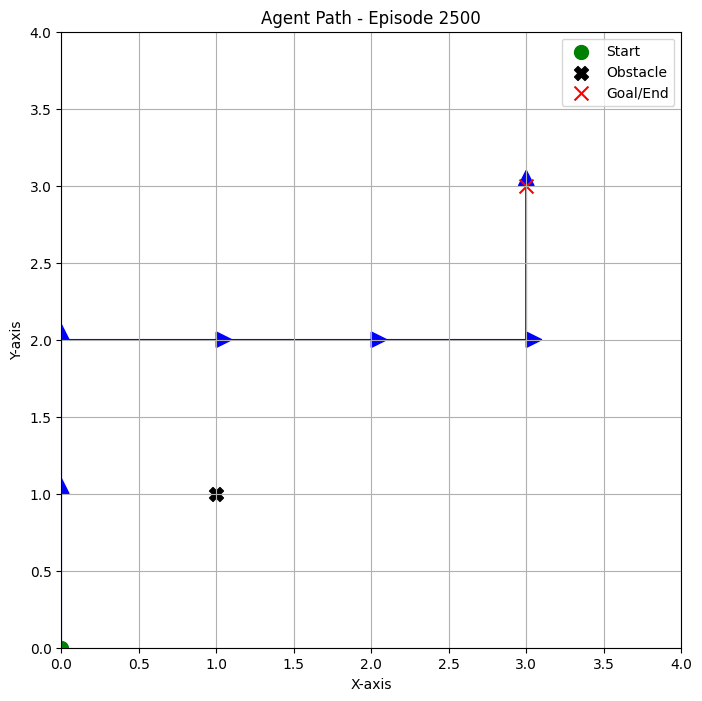

Episode: 2500, Avg. Reward: 38.2, Epsilon: 0.1


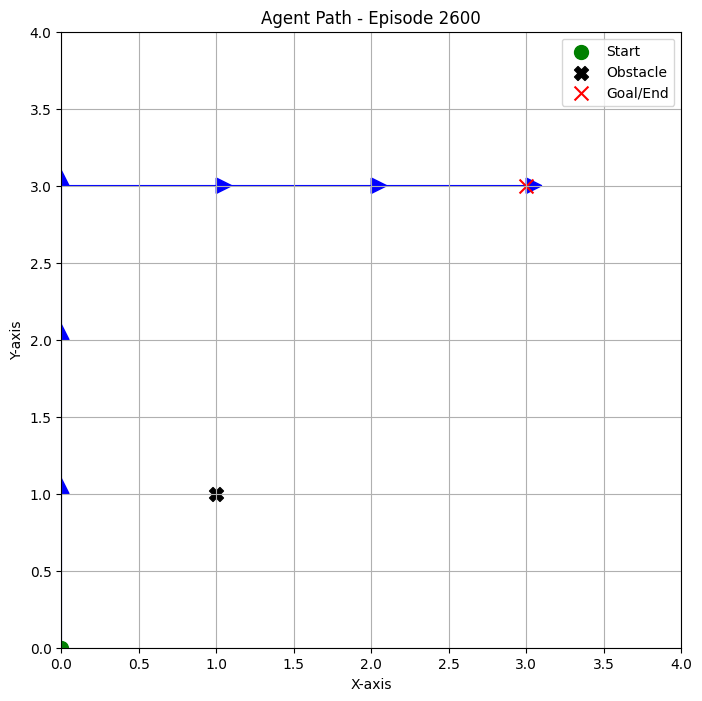

Episode: 2600, Avg. Reward: 39.14, Epsilon: 0.1


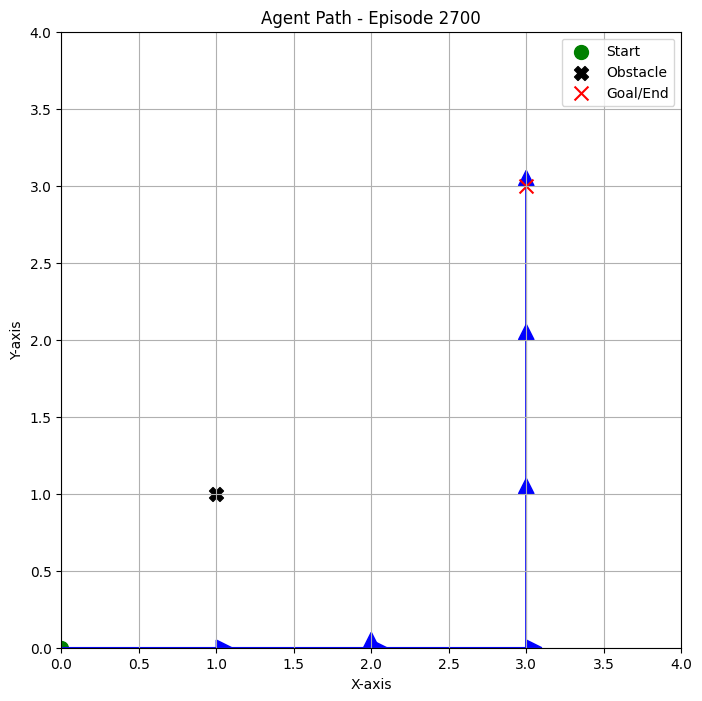

Episode: 2700, Avg. Reward: 38.52, Epsilon: 0.1


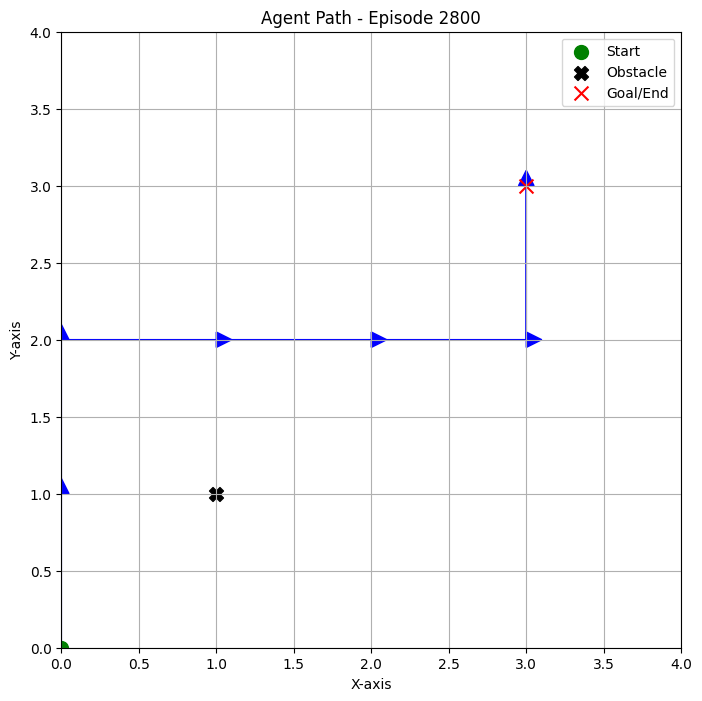

Episode: 2800, Avg. Reward: 39.12, Epsilon: 0.1


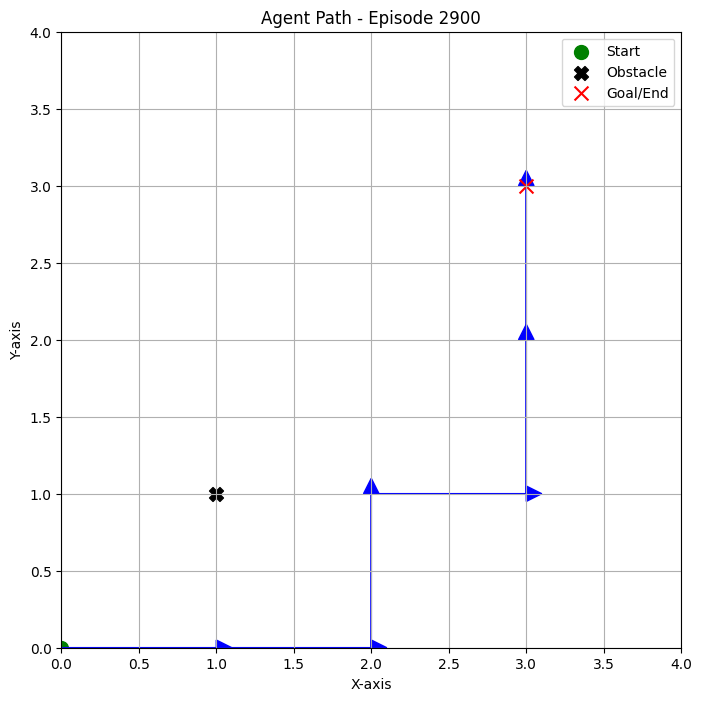

Episode: 2900, Avg. Reward: 38.46, Epsilon: 0.1


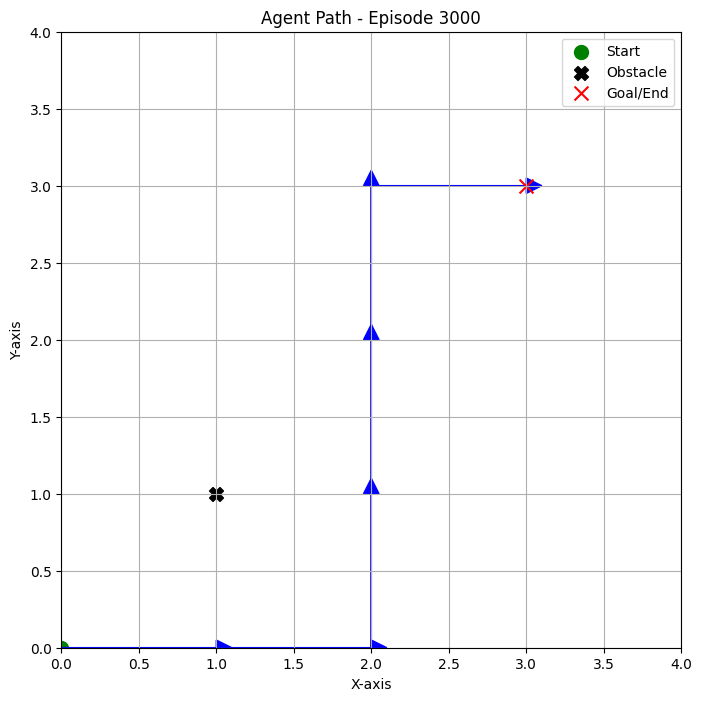

Episode: 3000, Avg. Reward: 39.04, Epsilon: 0.1


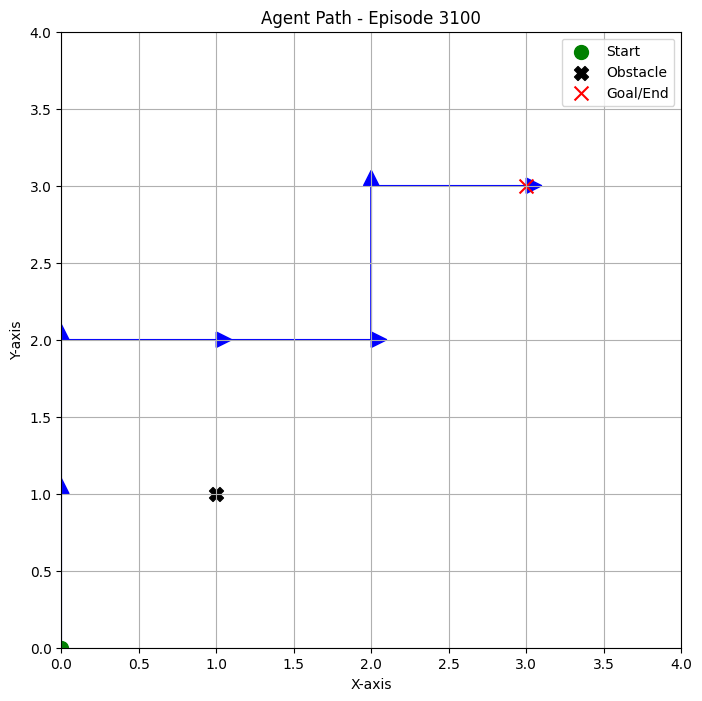

Episode: 3100, Avg. Reward: 38.72, Epsilon: 0.1


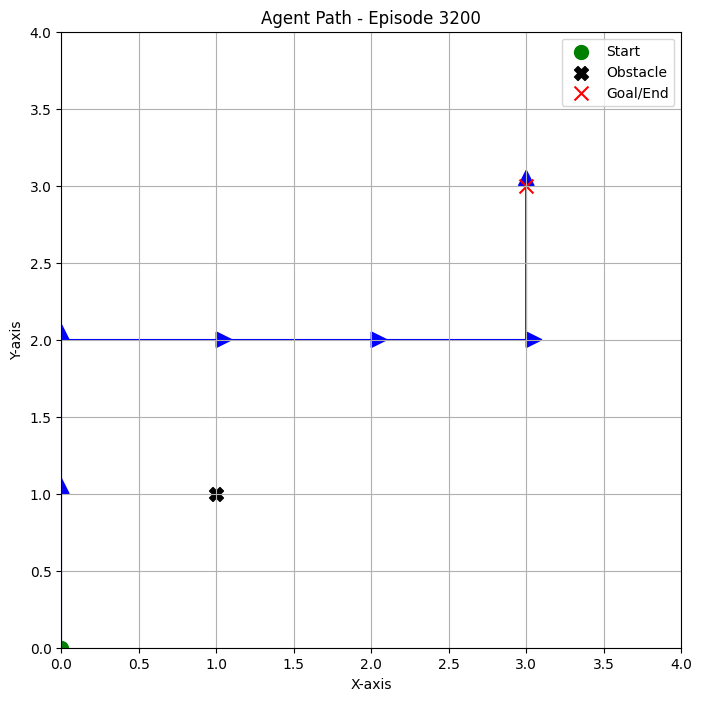

Episode: 3200, Avg. Reward: 38.52, Epsilon: 0.1


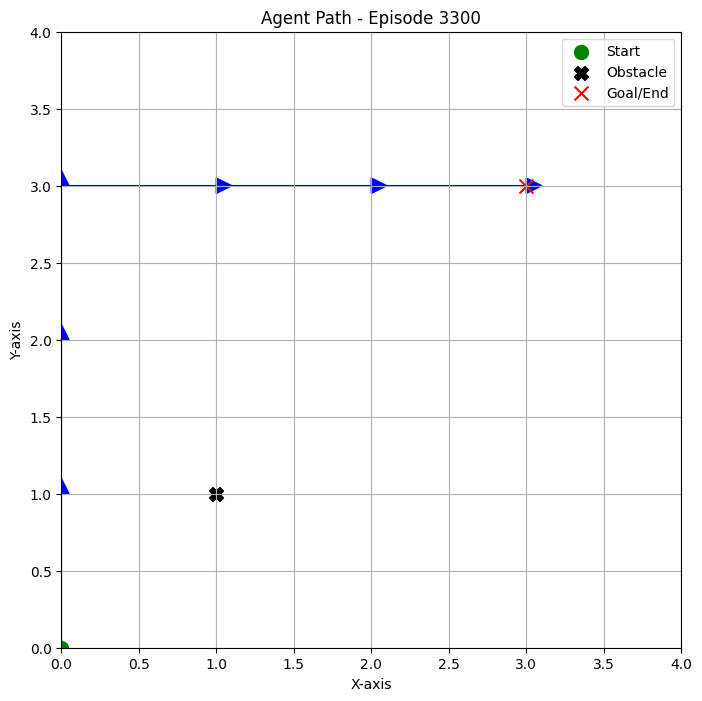

Episode: 3300, Avg. Reward: 38.96, Epsilon: 0.1


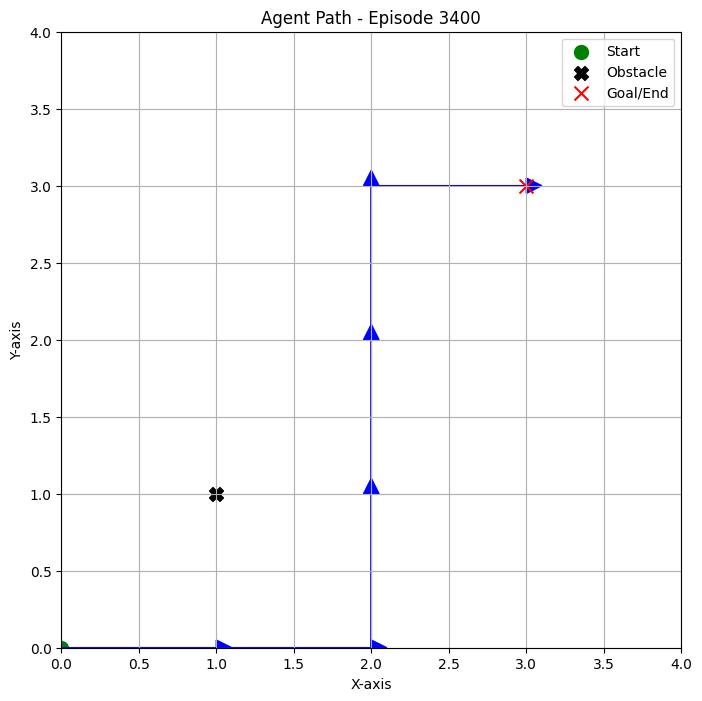

Episode: 3400, Avg. Reward: 38.42, Epsilon: 0.1


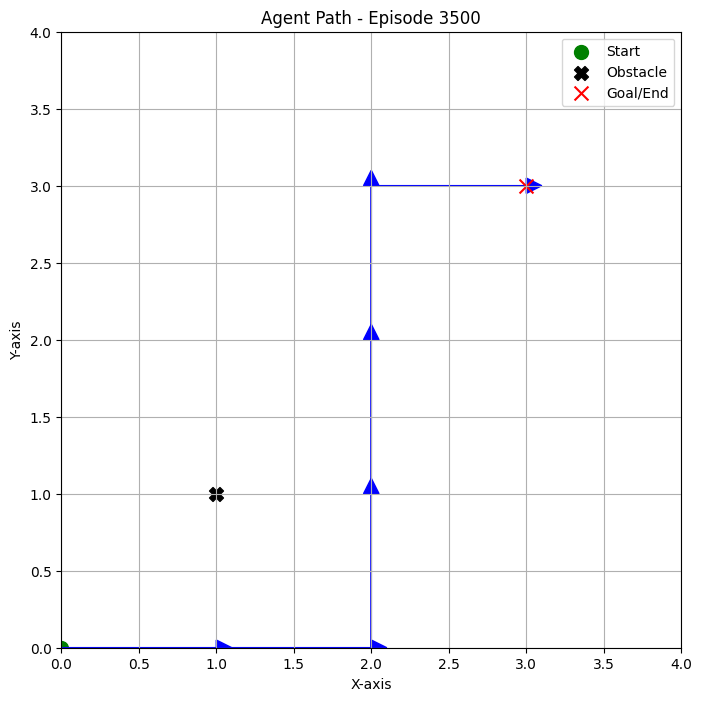

Episode: 3500, Avg. Reward: 38.78, Epsilon: 0.1


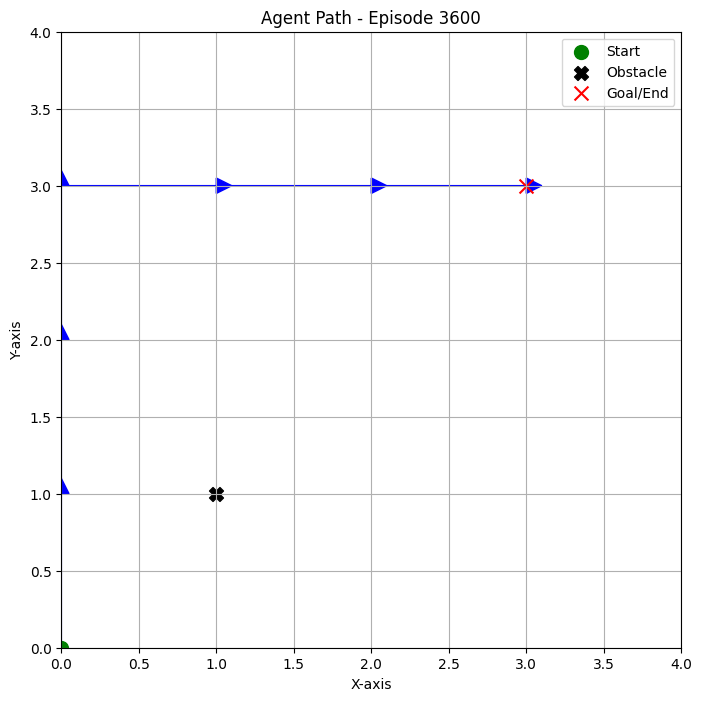

Episode: 3600, Avg. Reward: 38.92, Epsilon: 0.1


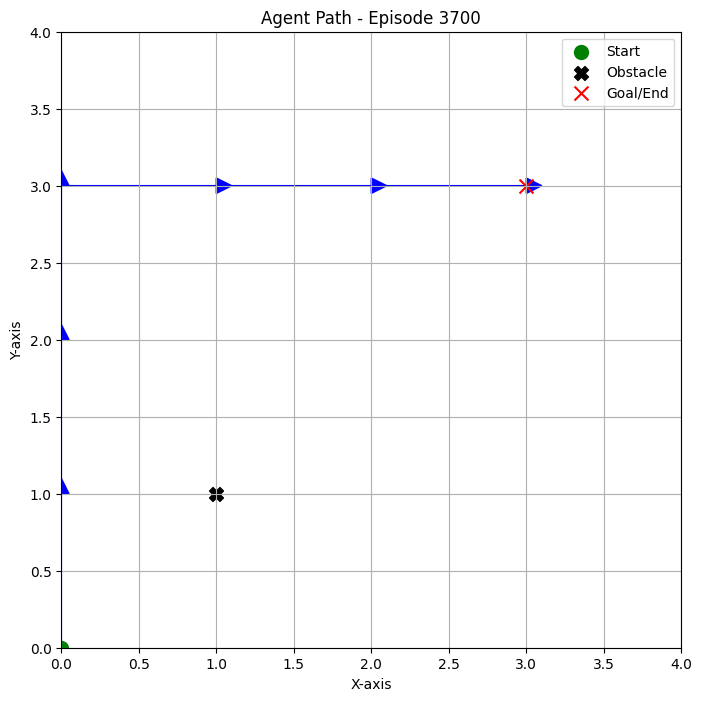

Episode: 3700, Avg. Reward: 38.7, Epsilon: 0.1


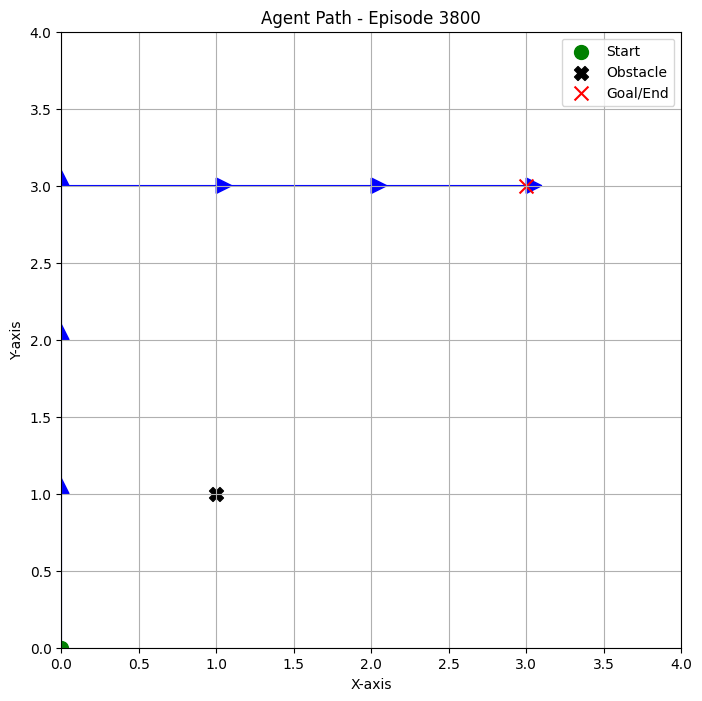

Episode: 3800, Avg. Reward: 38.94, Epsilon: 0.1


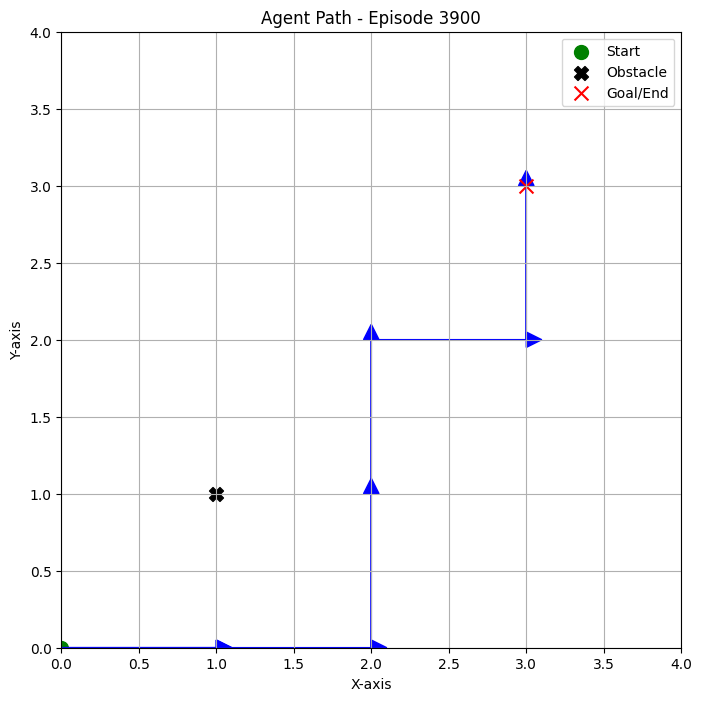

Episode: 3900, Avg. Reward: 38.86, Epsilon: 0.1


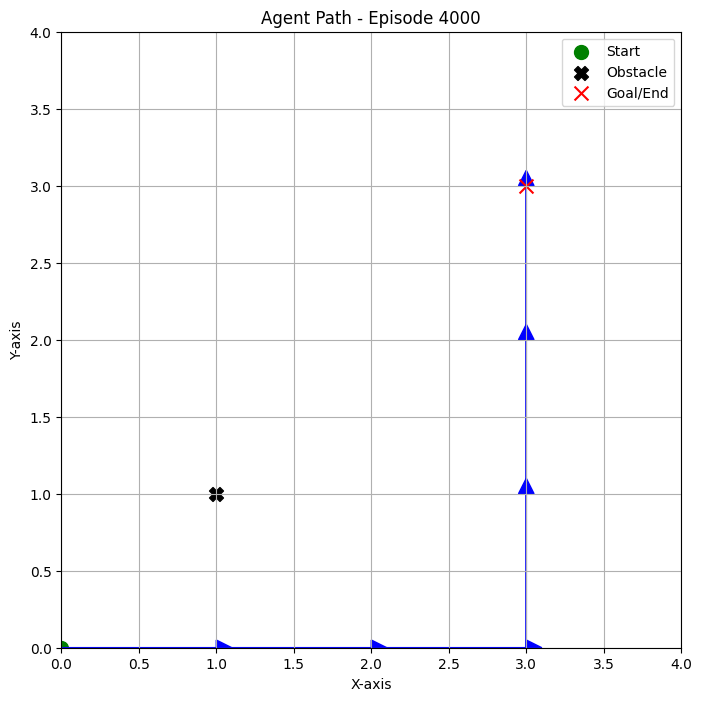

Episode: 4000, Avg. Reward: 38.74, Epsilon: 0.1


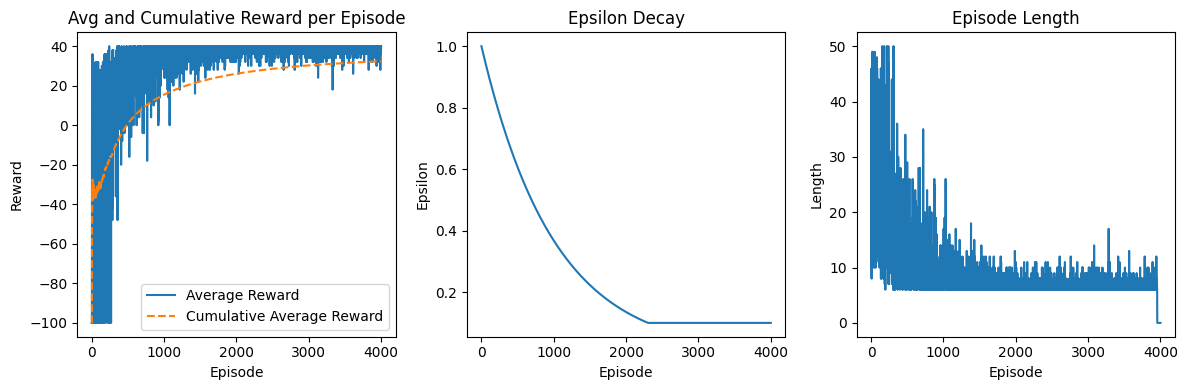

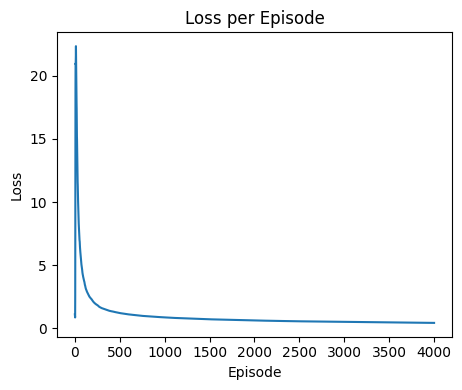

In [ ]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt



class CustomEnvironment:
    def __init__(self):
        self.grid_size = 4
        self.obstacle_pos = (1, 1)

        self.state = (0, 0)  # Initial state
        self.goal = (3, 3)

        self.state_history = []  # To store the agent's path


    def reset(self):
        self.state = (0, 0)
        self.state_history = []  # Clear state histor
        return self.state

    def step(self, action):
        x, y = self.state

        if action == 0:  # Move right
            x = min(x + 1, self.grid_size - 1)
        elif action == 1:  # Move left
            x = max(x - 1, 0)
        elif action == 2:  # Move up
            y = min(y + 1, self.grid_size - 1)
        elif action == 3:  # Move down
            y = max(y - 1, 0)

        # Check for obstacle
        if (x, y) == self.obstacle_pos:
            x, y = self.state

        self.state = (x, y)
        self.state_history.append(self.state)  # Add current state to history


        # Check if reached the goal
        done = (x, y) == self.goal or len(self.state_history) == 150 or (x,y) == self.obstacle_pos

        # Calculate reward

        if self.state == self.goal:
            reward = 50
            done = True
        elif self.state == self.obstacle_pos:
            reward = -20
            done = True
        else:
            reward = -2
            done = False

        return np.array(self.state), reward, done



# Define the neural network architecture
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the DQN agent with experience replay
class DQNAgent:
    def __init__(self, input_size, output_size, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.1, buffer_size=10000, batch_size=32):
        self.q_network = QNetwork(input_size, output_size)
        self.target_network = QNetwork(input_size, output_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.01)
        self.criterion = nn.MSELoss()
        self.losses = [] # Add a list to store loss values


        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.replay_memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3) # exploration i.e. choosing any random action
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state) # exploitation
            return q_values.argmax().item()

    def train(self):
        if len(self.replay_memory) < self.batch_size:
            return

        batch = random.sample(self.replay_memory, self.batch_size)
        state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*batch)

        state_batch = torch.FloatTensor(state_batch)
        next_state_batch = torch.FloatTensor(next_state_batch)
        action_batch = torch.LongTensor(action_batch)
        reward_batch = torch.FloatTensor(reward_batch)
        done_batch = torch.FloatTensor(done_batch)

        q_values = self.q_network(state_batch).gather(1, action_batch.unsqueeze(1))
        next_q_values = self.target_network(next_state_batch).max(1)[0].detach()
        target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values

        loss = self.criterion(q_values, target_q_values.unsqueeze(1))
        # Store the loss value
        self.losses.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    #def decay_epsilon(self):
        #self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
    #def decay_epsilon(self,episode):
        #self.epsilon = self.epsilon_start + (self.epsilon_start -  self.epsilon_min) *  math.exp(-1. * episode * self.epsilon_decay)

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay
          self.epsilon = max(self.epsilon, self.epsilon_min)


# Main training loop
def train_dqn():
    env = CustomEnvironment()
    input_size = 2
    output_size = 4
    agent = DQNAgent(input_size, output_size)

    num_episodes = 4000
    max_steps = 50
    target_update_frequency = 20  # Update target network every 10 steps


    avg_rewards = []
    epsilons = []
    episode_lengths = []
    agent_paths = []
    losses = []  # Initialize a list for losses


    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)
            agent.replay_memory.append((state, action, next_state, reward, done))
            agent.train()
            #agent.update_target_network()

            state = next_state
            total_reward += reward

            if done:
                episode_lengths.append(step + 1)
                break

            if step % target_update_frequency == 0:
                agent.update_target_network()


        avg_rewards.append(total_reward)
        epsilons.append(agent.epsilon)
        agent.decay_epsilon()

        if (episode + 1) % 100 == 0:
            agent_paths.append([state] + env.state_history)
            visualize_agent_path(agent, env, episode + 1)

        if (episode + 1) % 100 == 0:
            print(f"Episode: {episode + 1}, Avg. Reward: {np.mean(avg_rewards[-100:])}, Epsilon: {agent.epsilon}")

        losses.append(np.mean(agent.losses))  # Append the mean of losses

    plot_results(num_episodes, avg_rewards, epsilons, episode_lengths, losses)


# Helper function to visualize the agent's path
def visualize_agent_path(agent, env, episode):
    plt.figure(figsize=(8, 8))
    plt.title(f'Agent Path - Episode {episode}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    state = env.reset()
    plt.scatter(state[0], state[1], color='green', marker='o',s = 100, label='Start')

    for step in range(50):  # Assuming max_steps is 50
        action = agent.select_action(state)
        next_state, _, done = env.step(action)

        plt.arrow(
            state[0], state[1],  # Center the arrow in the grid cell
            next_state[0] - state[0], next_state[1] - state[1],
            head_width=0.1, head_length=0.1, fc='blue', ec='blue'
        )
        state = next_state

        if done:
            break

    # Check if there is an obstacle before plotting
    if env.obstacle_pos is not None:
        obstacle_marker = 'X'
        obstacle_color = 'black'
        plt.scatter(env.obstacle_pos[0], env.obstacle_pos[1], color=obstacle_color, marker=obstacle_marker, s=100, label='Obstacle')

    # Add marker for the goal or end
    if done and not np.any(state == env.goal):
        goal_marker = 's'  # square for non-goal end
        goal_color = 'orange'  # a different color
    else:
        goal_marker = 'x'
        goal_color = 'red'


    plt.scatter(state[0], state[1], color='red', marker='x',s=100, label='Goal/End')

    # Add a marker for the end position when the episode is done but not at the goal
    if done and not np.any(state == env.goal):
        plt.scatter(state[0], state[1], color='black', marker='X', s=100, label='End (Max Steps)')


    plt.legend()
    plt.grid(True)

    # Set axis limits to ensure a fixed grid size
    plt.xlim(0, env.grid_size)
    plt.ylim(0, env.grid_size)
    plt.show()

# Helper function to plot the agent's paths
def plot_agent_paths(agent_paths):
    plt.figure(figsize=(8, 8))
    plt.title('Agent Paths After Every 100 Episodes')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    for i, path in enumerate(agent_paths):
        xs, ys = zip(*path)
        plt.plot(xs, ys, label=f'Episode {100 * (i + 1)}')

    plt.scatter(xs[0], ys[0], color='green', marker='o', label='Start')
    plt.scatter(xs[-1], ys[-1], color='red', marker='x', label='Goal')
    plt.legend()
    plt.grid(True)
    plt.show()


# Helper function to plot the results

def plot_results(num_episodes, avg_rewards, epsilons, episode_lengths,losses):
    # Calculate cumulative average rewards
    cum_avg_rewards = [sum(avg_rewards[:i+1]) / (i+1) for i in range(num_episodes)]

    # Average Reward Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)

    # Plot Average Reward per Episode
    plt.plot(range(1, num_episodes + 1), avg_rewards, label='Average Reward')

    # Plot Cumulative Average Reward
    plt.plot(range(1, num_episodes + 1), cum_avg_rewards, label='Cumulative Average Reward', linestyle='--')

    plt.legend()  # Show legend to differentiate between the two lines
    plt.title('Avg and Cumulative Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')



    # Epsilon Decay Plot
    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_episodes + 1), epsilons)
    plt.title('Epsilon Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')

    # Episode Length Plot
    plt.subplot(1, 3, 3)
    #episode_lengths = episode_lengths[:num_episodes]
    #plt.plot(range(1, num_episodes + 1), episode_lengths)
    episode_lengths.extend([0] * (num_episodes - len(episode_lengths)))
    plt.plot(range(1, num_episodes + 1), episode_lengths)
    plt.title('Episode Length')
    plt.xlabel('Episode')
    plt.ylabel('Length')

    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(18, 4))  # Adjust the figure size if needed
    plt.subplot(1, 4, 4)
    plt.plot(range(1, num_episodes + 1), losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_dqn()